<a href="https://colab.research.google.com/github/ramapriyakj/ML6/blob/master/tensorflow_ml6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
data_set_dir = root_dir + 'Colab Notebooks/dataset/data/'

In [0]:
import os
import cv2
import numpy as np

def create_data_with_labels(image_dir):
    """Gets numpy data and label array from images that are in the folders that are
    in the folder which was given as a parameter. The folders that are in that folder
    are identified by the mug they represent and the folder name starts with the label."""
    mug_dirs = [f for f in os.listdir(image_dir) if not f.startswith('.')]
    mug_files = []

    for mug_dir in mug_dirs:
        mug_image_files = [image_dir + mug_dir + '/' + '{0}'.format(f)
                           for f in os.listdir(image_dir + mug_dir) if not f.startswith('.')]
        mug_files += [mug_image_files]

    num_images = len(mug_files[0])
    images_np_arr = np.empty([len(mug_files), num_images, 64, 64, 3], dtype=np.float32)

    for mug, _ in enumerate(mug_files):
        for mug_image in range(num_images):
            img = cv2.imread(mug_files[mug][mug_image])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)
            images_np_arr[mug][mug_image] = img / 255.

    data = images_np_arr[0]
    labels = np.full(num_images, int(mug_dirs[0][0]))

    for i in range(1, len(mug_dirs)):
        data = np.append(data, images_np_arr[i], axis=0)
        labels = np.append(labels, np.full(num_images, int(mug_dirs[i][0])), axis=0)

    return data, labels

In [3]:
def read_train_data():
  global train_data
  global train_labels  
  (train_data, train_labels) = create_data_with_labels(data_set_dir+"train/")
  print("Train ",train_data.shape,train_labels.shape)

def read_eval_data():
  global eval_data
  global eval_labels
  (eval_data, eval_labels) = create_data_with_labels(data_set_dir+"test/")
  print("Eval ",eval_data.shape,eval_labels.shape)
  
read_train_data()
read_eval_data()

Train  (2000, 64, 64, 3) (2000,)
Eval  (1000, 64, 64, 3) (1000,)


In [0]:
import matplotlib.pyplot as plt

def printResults(history):
  loss = history['loss']
  accuracy = history['accuracy']
  epochs = range(len(loss))
  
  plt.figure()
  plt.plot(epochs, loss, 'b', label='loss')
  plt.title('loss')
  plt.show()
  
  plt.figure()
  plt.plot(epochs, accuracy, 'b', label='accuracy')
  plt.title('accuracy')
  plt.show()

In [0]:
"""This file contains all the model information: the training steps, the batch size and the model iself."""
import math
import tensorflow as tf

def get_training_steps():
    """Returns the number of batches that will be used to train your solution.
    It is recommended to change this value."""
    return 3000

def get_batch_size():
    """Returns the batch size that will be used by your solution.
    It is recommended to change this value."""
    return 40
	
def getModel(features):
  # Input Layer (a batch of images that have 64x64 pixels and are RGB colored (3)
  model = tf.reshape(features["x"], [-1, 64, 64, 3])
  
  model = tf.layers.Conv2D(32,1,activation=tf.nn.relu)(model)
  model = tf.layers.Conv2D(32,1,activation=tf.nn.relu)(model)
  model = tf.layers.MaxPooling2D(3,3)(model)
  
  model = tf.layers.Conv2D(32,2,activation=tf.nn.relu)(model)
  model = tf.layers.Conv2D(32,2,activation=tf.nn.relu)(model)
  model = tf.layers.MaxPooling2D(3,3)(model)
  
  model = tf.layers.Conv2D(32,1,activation=tf.nn.relu)(model)
  model = tf.layers.Conv2D(32,1,activation=tf.nn.relu)(model)
  model = tf.layers.MaxPooling2D(3,3)(model)
  
  model = tf.layers.Flatten()(model)
  
  model = tf.layers.Dense(512,activation=tf.nn.relu)(model)
  model = tf.layers.Dropout(0.4)(model)
  
  model = tf.layers.Dense(128,activation=tf.nn.relu)(model)
  model = tf.layers.Dropout(0.1)(model)
  
  model = tf.layers.Dense(64,activation=tf.nn.relu)(model)
  model = tf.layers.Dropout(0.1)(model)
  
  model = tf.layers.Dense(4)(model)
  return model

def solution(features, labels, mode):

    logits = getModel(features)
    
    predictions = {
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
        
    if mode == tf.estimator.ModeKeys.PREDICT:
      return tf.estimator.EstimatorSpec(mode=mode,predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
		
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.contrib.opt.AdamWOptimizer(0.001)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
      
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode=mode,loss=loss,eval_metric_ops=eval_metric_ops)

{'accuracy': 0.53, 'loss': 3.8892272, 'global_step': 100}
{'accuracy': 0.534, 'loss': 2.256595, 'global_step': 200}
{'accuracy': 0.635, 'loss': 1.7955741, 'global_step': 300}
{'accuracy': 0.584, 'loss': 1.5113015, 'global_step': 400}
{'accuracy': 0.487, 'loss': 2.9180732, 'global_step': 500}
{'accuracy': 0.549, 'loss': 1.7958324, 'global_step': 600}
{'accuracy': 0.629, 'loss': 1.5966076, 'global_step': 700}
{'accuracy': 0.706, 'loss': 0.8463258, 'global_step': 800}
{'accuracy': 0.699, 'loss': 1.0913227, 'global_step': 900}
{'accuracy': 0.741, 'loss': 0.95179796, 'global_step': 1000}
{'accuracy': 0.717, 'loss': 1.3119665, 'global_step': 1100}
{'accuracy': 0.636, 'loss': 1.299149, 'global_step': 1200}
{'accuracy': 0.723, 'loss': 0.80536056, 'global_step': 1300}
{'accuracy': 0.705, 'loss': 0.9266562, 'global_step': 1400}
{'accuracy': 0.699, 'loss': 0.8223446, 'global_step': 1500}
{'accuracy': 0.638, 'loss': 1.3152076, 'global_step': 1600}
{'accuracy': 0.689, 'loss': 1.932455, 'global_step

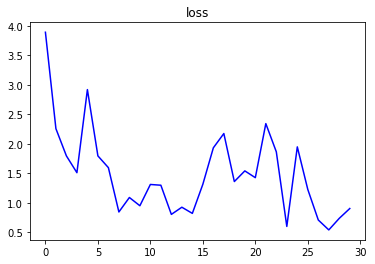

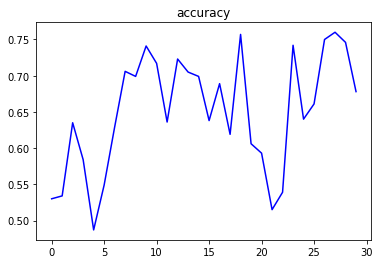

In [13]:
import argparse
import os
import tensorflow as tf
from tensorflow.contrib.training.python.training import hparam
from keras.preprocessing.image import ImageDataGenerator

def train_input_fn():
  x,y = next(train_generator)
  return {"x":x},y

def train_model(params):
    global train_generator 
    batch_size=get_batch_size()
    train_datagen = ImageDataGenerator(width_shift_range=0.4,height_shift_range=0.4,shear_range=0.1,zoom_range=0.1,fill_mode='nearest')
    train_generator = train_datagen.flow(train_data,train_labels,batch_size=batch_size)
    
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": eval_data},
        y=eval_labels,
        num_epochs=1,
        shuffle=False)

    estimator = tf.estimator.Estimator(model_fn=solution)

    steps_per_eval = int(get_training_steps() / params.eval_steps)
    
    history = {}
    history["loss"] = []
    history["accuracy"]= []
    for _ in range(params.eval_steps):
        estimator.train(train_input_fn, steps=steps_per_eval)
        eval_results = estimator.evaluate(eval_input_fn)
        print(eval_results)
        history["loss"].append(eval_results["loss"])
        history["accuracy"].append(eval_results["accuracy"])
    printResults(history)
        
class pp:
  eval_steps = 30

tf.logging.set_verbosity('ERROR')
HPARAMS = pp()
train_model(HPARAMS)